In [1]:
#shenanigans so python finds weak_sauce module 
import sys
sys.path.append('/u/ki/mbaumer/random_pixel_size/weak_sauce/code')
print sys.path

['', '/u/ki/mbaumer/local/pappy', '/afs/slac/g/ki/software/heasoft/6.16/amd64_rhel60/heasoft/x86_64-unknown-linux-gnu-libc2.12/lib/python', '/afs/slac/g/ki/software/heasoft/6.16/amd64_rhel60/heasoft/x86_64-unknown-linux-gnu-libc2.12/lib', '/afs/slac.stanford.edu/u/ki/mbaumer/random_pixel_size/weak_sauce/notebooks', '/u/ki/mbaumer/local/lib/python2.7/site-packages', '/u/ki/mbaumer/anaconda/lib/python27.zip', '/u/ki/mbaumer/anaconda/lib/python2.7', '/u/ki/mbaumer/anaconda/lib/python2.7/plat-linux2', '/u/ki/mbaumer/anaconda/lib/python2.7/lib-tk', '/u/ki/mbaumer/anaconda/lib/python2.7/lib-old', '/u/ki/mbaumer/anaconda/lib/python2.7/lib-dynload', '/u/ki/mbaumer/.local/lib/python2.7/site-packages', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages/Sphinx-1.3.1-py2.7.egg', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages/cryptography-0.9.1-py2.7-linux-x86_64.egg', '/u/ki/mbaumer/anaconda/lib/python2.7/site-packages/setuptools-17.1.1-p

In [2]:
%matplotlib inline
import weak_sauce as ws
import weak_sauce.data_tools
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

from weak_sauce.movers import UniformGaussianMover
from weak_sauce.grid import MoveableGrid
from weak_sauce.sources import Source
from weak_sauce.movers import UniformIlluminationMover, FixedIlluminationMover
from weak_sauce.fit_flat import FlatFitter

def gauss(centroids, mu=np.array([0, 0]), sigma=np.array([1., 1.])):
    return np.exp(-0.5 * np.sum(np.square((centroids - mu) / sigma), axis=2)) / \
           (2 * np.pi * np.prod(sigma))
    
import galsim

(<matplotlib.figure.Figure at 0x7f2d67bc3550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2d67ad6d90>)

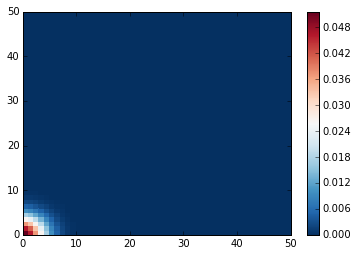

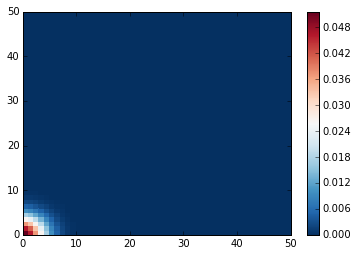

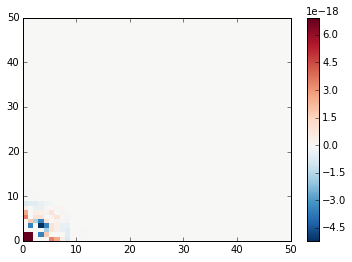

In [3]:
src1 = Source(num_x=51,flux_func=gauss,sigma=3)
test_galsim = galsim.Gaussian(sigma=3,flux=3)
src2 = Source(num_x=51,flux_func=test_galsim)
src1.plot_pixel_grid()
src2.plot_pixel_grid()
src1.plot(src1.fluxes-src2.fluxes)

So the galsim gaussian object (with flux=3) matches the hand-coded gaussian flux_func to 1 part in 10^17, so we're good!

##Alternative to flux measured by AdaptiveMoments: photutils

In [4]:
test_gauss = galsim.Gaussian(sigma=3,flux=2)
test_gauss = test_gauss.shift(15,15)
phot_src = Source(num_x=51,flux_func=test_gauss)

(<matplotlib.figure.Figure at 0x7f2d982c9b90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2d98266b10>)

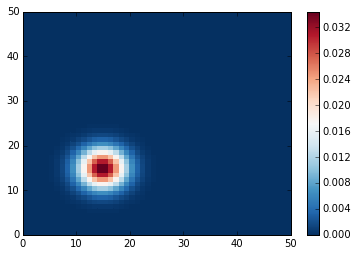

In [5]:
phot_src.plot_pixel_grid()

In [6]:
res = phot_src.evaluate_psf()
print res[['flux','Mx','My','e1','e2']]
np.sum(phot_src.fluxes)

   flux    Mx    My            e1            e2
0     1  14.5  14.5 -4.350945e-10  9.596366e-12


1.9999989817297581

For some reason, the flux measured by adaptive moments is half the sum over all the pixels...but whatever; let's press on

photutils seems interesting, but I'm not sure how many people will belive the numbers...let's go with sextractor for now. pysex is really old and poorly documented, but I can make sewpy do what I want with only a few extra lines...

In [7]:
phot_src.evaluate_sex()

TypeError: coercing to Unicode: need string or buffer, dict found

In [14]:
from photutils import CircularAperture
from photutils import aperture_photometry
apertures = CircularAperture((res['Mx'],res['My']), r=9.)
phot_table = aperture_photometry(phot_src.fluxes, apertures)
print phot_table

 aperture_sum  xcenter [1]   ycenter [1] 
                                         
------------- ------------- -------------
1.97702425595 14.4999999987 14.4999999997


In [85]:
def sexArray(img):
    """
    Run sextractor on a numpy array (or weak_sauce source) to do photometry.
    """
    import sewpy, os
    sew = sewpy.SEW(params=["X_IMAGE", "Y_IMAGE", "FLUX_AUTO", "FLUX_ISO", "FLUX_ISOCOR", "FLAGS"],
            config={"DETECT_MINAREA":10, "PHOT_FLUXFRAC":"0.3, 0.5, 0.8"}, sexpath='/afs/slac/g/ki/software/local/bin/sex')
    from astropy.io import fits
    if type(img) == eval('np.ndarray'):
        hdu = fits.PrimaryHDU(img)
    elif hasattr(img,'fluxes'):
        hdu = fits.PrimaryHDU(img.fluxes)
    else:
        raise TypeError('img should be either an numpy array or a weak_sauce source')
    hdulist = fits.HDUList([hdu])
    hdulist.writeto('temp.fits',clobber=True)
    out = sew('temp.fits')
    os.remove('temp.fits')
    return out["table"] # this is an astropy table.